In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
train = pd.read_csv('trainM.csv')
test = pd.read_csv('testM.csv')


In [4]:
train = train.rename(columns={'Unnamed: 0': 'date_forecast'})
test = test.rename(columns={'Unnamed: 0': 'date_forecast'})

In [5]:
train.set_index('date_forecast', inplace=True)
test.set_index('date_forecast', inplace=True)
train.index = pd.to_datetime(train.index)
#test = test.drop(columns = ['date_calc'])

In [6]:
columns_only_in_df2 = train.columns.difference(test.columns)

# Visualizza le colonne uniche in ciascun DataFrame
print("Colonne presenti solo in df1:")
print(columns_only_in_df2)

Colonne presenti solo in df1:
Index(['pv_measurement'], dtype='object')


In [7]:
import re
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train['is_est'] = 0
train['is_est'].iloc[-4418:] = 1


C:\Users\claxl\AppData\Local\Temp\ipykernel_26776\2428353307.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['is_est'].iloc[-4418:] = 1


<Axes: ylabel='Frequency'>

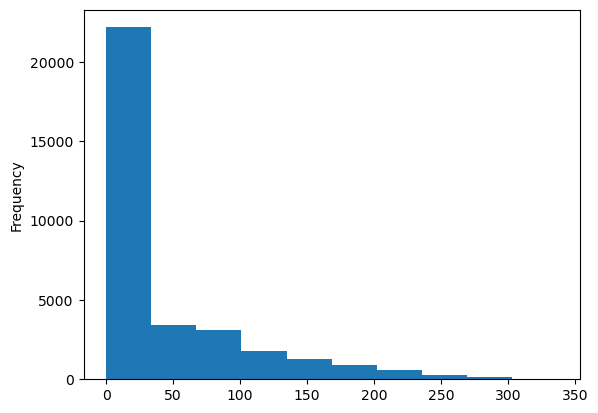

In [8]:
train['diffuse_radW'].plot.hist()


<Axes: ylabel='Frequency'>

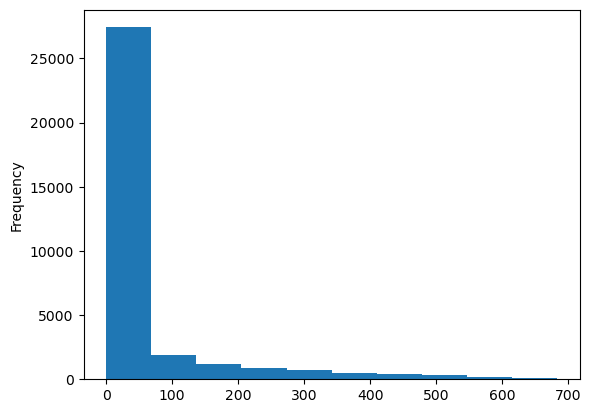

In [9]:
train['direct_radW'].plot.hist()

In [10]:
nan_col = ['snow_densitykgm3','ceiling_height_aglm','cloud_base_aglm']
test['snow_densitykgm3'].fillna(0)
for col in nan_col:
    
    test[col] = test[col].fillna(0)
    train[col] = train[col].fillna(train[col].median())

train=train.dropna()
test=test.dropna()

In [11]:
train.columns

Index(['absolute_humidity_2mgm3', 'air_density_2mkgm3', 'ceiling_height_aglm',
       'clear_sky_energy_1hJ', 'clear_sky_radW', 'cloud_base_aglm',
       'dew_or_rimeidx', 'dew_point_2mK', 'diffuse_radW', 'diffuse_rad_1hJ',
       'direct_radW', 'direct_rad_1hJ', 'effective_cloud_coverp', 'elevationm',
       'fresh_snow_12hcm', 'fresh_snow_1hcm', 'fresh_snow_24hcm',
       'fresh_snow_3hcm', 'fresh_snow_6hcm', 'is_dayidx', 'is_in_shadowidx',
       'msl_pressurehPa', 'precip_5minmm', 'precip_type_5minidx',
       'pressure_100mhPa', 'pressure_50mhPa', 'prob_rimep', 'rain_waterkgm2',
       'relative_humidity_1000hPap', 'sfc_pressurehPa', 'snow_densitykgm3',
       'snow_depthcm', 'snow_driftidx', 'snow_melt_10minmm', 'snow_waterkgm2',
       'sun_azimuthd', 'sun_elevationd', 'super_cooled_liquid_waterkgm2',
       't_1000hPaK', 'total_cloud_coverp', 'visibilitym', 'wind_speed_10mms',
       'wind_speed_u_10mms', 'wind_speed_v_10mms', 'wind_speed_w_1000hPams',
       'minute', 'hour', 

In [12]:
train.shape, test.shape

((26071, 50), (720, 48))

In [13]:
train['pv_measurement'] = train['pv_measurement'].mask(train['is_in_shadowidx'] == 1, 0)


<Axes: xlabel='date_forecast'>

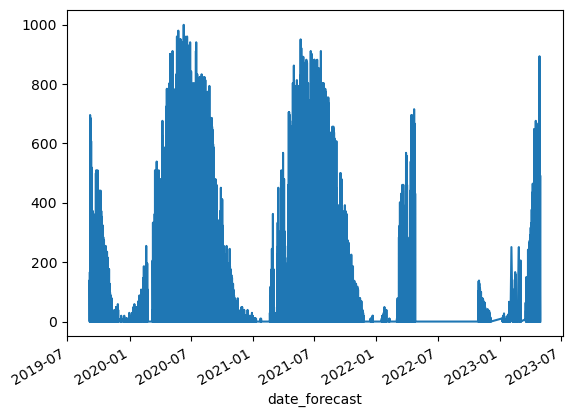

In [14]:
train['pv_measurement'].plot()

In [15]:
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

In [47]:
def outlier_detect_ZScore(data, col, threshold=3):
    '''
    Outlier detection by Z-Score method. 
    Calculate the Z-score for each data point.
    Any value beyond:
        upper bound = mean + (Z-score * threshold * standard deviation)
        lower bound = mean - (Z-score * threshold * standard deviation)   
    are regarded as outliers. Default threshold is 3.
    
    Parameters:
    - data: The pandas DataFrame containing the data.
    - col: The name of the column in the DataFrame to perform outlier detection on.
    - threshold: The Z-score threshold for defining outliers. Default is 3.
    
    Returns:
    - outlier_index: A boolean Series indicating which rows are outliers.
    - para: Tuple containing the upper and lower bounds for outliers.
    '''
    mean = data[col].mean()
    std = data[col].std()
    Upper_fence = mean + (threshold * std)
    Lower_fence = mean - (threshold * std)
    para = (Lower_fence, Upper_fence)
    z_scores = (data[col] - mean) / std
    outlier_index = (z_scores > threshold) | (z_scores < -threshold)
    if outlier_index.any():
        num_outliers = outlier_index.value_counts()[True]
        print(f'Num of outliers detected: {num_outliers} in column {col}')
        percentage_of_outliers = (num_outliers / len(data)) * 100
        print(f'Percentage of outliers: {percentage_of_outliers:.2f}% relative to {len(data)} data points')
        print('————————————————————————————————————————————————————')
    return outlier_index, para
def remove_outliers_ZScore(data, col, threshold=3):
    outlier_index, _ = outlier_detect_ZScore(data, col, threshold)
    data_cleaned = data[~outlier_index]
    return data_cleaned

In [48]:
for col in train.columns:
    data_without_outliers = remove_outliers_ZScore(train, col, threshold=3)


Num of outliers detected: 92 in column absolute_humidity_2mgm3
Percentage of outliers: 0.27% relative to 34061 data points
————————————————————————————————————————————————————
Num of outliers detected: 262 in column air_density_2mkgm3
Percentage of outliers: 0.77% relative to 34061 data points
————————————————————————————————————————————————————
Num of outliers detected: 552 in column ceiling_height_aglm
Percentage of outliers: 1.62% relative to 34061 data points
————————————————————————————————————————————————————
Num of outliers detected: 1019 in column cloud_base_aglm
Percentage of outliers: 2.99% relative to 34061 data points
————————————————————————————————————————————————————
Num of outliers detected: 1210 in column dew_or_rimeidx
Percentage of outliers: 3.55% relative to 34061 data points
————————————————————————————————————————————————————
Num of outliers detected: 69 in column dew_point_2mK
Percentage of outliers: 0.20% relative to 34061 data points
———————————————————————————

In [16]:
train['hours'] = train.index.hour
train['day'] = train.index.day
train['month'] = train.index.month
train['year'] = train.index.year
train['dayofyear'] = train.index.dayofyear

In [17]:
train['total_rad'] = train['direct_radW'] + train['diffuse_radW']
test['total_rad'] = test['direct_radW'] + test['diffuse_radW']

In [17]:
train['total*cloud'] = train['total_rad'] * train['total_cloud_coverp']
test['total*cloud'] = test['total_rad'] * test['total_cloud_coverp']

In [18]:
train['direct*cloud'] = train['direct_radW'] * train['total_cloud_coverp']
test['direct*cloud'] = test['direct_radW'] * test['total_cloud_coverp']

In [19]:
train['dif*cloud'] = train['diffuse_radW'] * train['total_cloud_coverp']
test['dif*cloud'] = test['diffuse_radW'] * test['total_cloud_coverp']

In [20]:
train['total*eff'] = train['total_rad'] * train['effective_cloud_coverp']
test['total*eff'] = test['total_rad'] * test['effective_cloud_coverp']

In [21]:
train['direct*eff'] = train['direct_radW'] * train['effective_cloud_coverp']
test['dircet*eff'] = test['direct_radW'] * test['effective_cloud_coverp']

In [22]:
train['diff*eff'] = train['diffuse_radW'] * train['effective_cloud_coverp']
test['diff*eff'] = test['diffuse_radW'] * test['effective_cloud_coverp']

In [23]:
test['hours'] = test.index.hour
test['day'] = test.index.day
test['month'] = test.index.month
test['year'] = test.index.year
test['dayofyear'] = test.index.dayofyear

In [24]:
# Supponiamo che "gruppi" sia il risultato della suddivisione
gruppi = train.groupby('is_est')

# Itera attraverso i gruppi e crea un DataFrame separato per ciascun gruppo
dataframes_per_gruppo = {}
for valore, gruppo in gruppi:
    dataframes_per_gruppo[valore] = gruppo.copy()
train_set = dataframes_per_gruppo[0]
val_set = dataframes_per_gruppo[1]

In [25]:
train_set = train_set.drop(columns = ['is_est'])
val_set = val_set.drop(columns = ['is_est'])

In [26]:
train = train.drop(columns = ['is_est'])

In [27]:
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
def objective(trial):
    param = {
            'metric': 'mae', 
            'random_state': 42,
            'n_estimators': trial.suggest_int('n_estimators',10,1000),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,1e-1),
            'max_depth': trial.suggest_int('max_depth', 1,50),
            'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),
            'verbosity': -1
        }
    model = lgb.LGBMRegressor(**param)

        # Extract target variable for training and testing data
    y_train = train_set['pv_measurement']
    y_val = val_set['pv_measurement']

        # Extract features for training and testing data
    X_train = train_set.drop(columns = 'pv_measurement')
    X_val = val_set.drop(columns = 'pv_measurement')
        
        # Train the XGBoost model
    model.fit(X_train, y_train,eval_set=[(X_val,y_val)])

        # Make predictions on the test data
    y_pred = model.predict(X_val)

        # Evaluate the model using Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_val, y_pred)
    return mae

In [28]:
import optuna
import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)
study = optuna.create_study(direction='minimize')

[I 2023-11-01 15:56:56,673] A new study created in memory with name: no-name-25e30598-430f-49e3-a1f5-bb4b151a549a


In [29]:
study.optimize(objective, n_trials=50)

[I 2023-11-01 15:56:57,356] Trial 0 finished with value: 691.6751086606101 and parameters: {'n_estimators': 268, 'reg_alpha': 0.41928973797264646, 'reg_lambda': 0.027665319050023934, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.0003365215999398983, 'max_depth': 3, 'num_leaves': 872, 'min_child_samples': 127, 'min_data_per_groups': 16}. Best is trial 0 with value: 691.6751086606101.
[I 2023-11-01 15:57:00,679] Trial 1 finished with value: 123.15147371485769 and parameters: {'n_estimators': 842, 'reg_alpha': 0.0349097669606076, 'reg_lambda': 0.016071921029198216, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.007698652696715542, 'max_depth': 42, 'num_leaves': 348, 'min_child_samples': 262, 'min_data_per_groups': 9}. Best is trial 1 with value: 123.15147371485769.
[I 2023-11-01 15:57:01,291] Trial 2 finished with value: 315.5144198375455 and parameters: {'n_estimators': 106, 'reg_alpha': 0.00139782836092753, 'reg_lambda': 0.009366008403215088, 'colsample_by

KeyboardInterrupt: 

In [30]:
trial = study.best_trial

print("  Value: {}".format(trial.value))
print(trial.params)

  Value: 120.09614479424714
{'n_estimators': 875, 'reg_alpha': 0.0040927482206393456, 'reg_lambda': 0.17463821883562997, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.0068160667854162095, 'max_depth': 9, 'num_leaves': 467, 'min_child_samples': 125, 'min_data_per_groups': 45}


In [31]:
model_A = lgb.LGBMRegressor(**trial.params)

In [32]:
X_train = train.drop(columns = 'pv_measurement')
y_train = train['pv_measurement']

In [33]:
pd.set_option('display.max_columns', 184)

test.shape,train.shape

((720, 59), (34061, 60))

In [34]:
model_A.fit(X_train,y_train)
y_pred_A = model_A.predict(test)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9587
[LightGBM] [Info] Number of data points in the train set: 34061, number of used features: 53
[LightGBM] [Info] Start training from score 629.398666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: min_data_per_groups


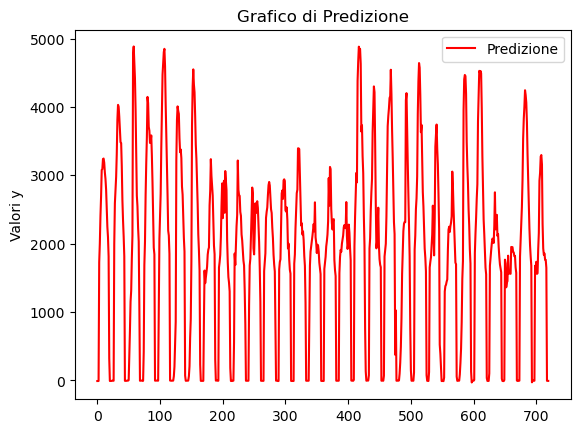

In [35]:
plt.plot(range(len(y_pred_A)), (y_pred_A), label='Predizione', color='red', linestyle='-')
# Aggiungi una legenda
plt.legend()

# Aggiungi etichette agli assi
plt.ylabel('Valori y')

# Titolo del grafico
plt.title('Grafico di Predizione')

# Mostra il grafico
plt.show()

In [36]:
df = pd.DataFrame({'Prediction':y_pred_A})

In [37]:
test = test.reset_index()
df.loc[test['is_in_shadowidx'] == 1, 'Prediction'] = 0


In [38]:
df.to_csv('A5.csv')

In [39]:
df

Prediction
0       0.000000
1       0.000000
2       0.000000
3    1729.132191
4    2004.045634
..           ...
715  1763.359292
716  1646.802337
717     0.000000
718     0.000000
719     0.000000

[720 rows x 1 columns]

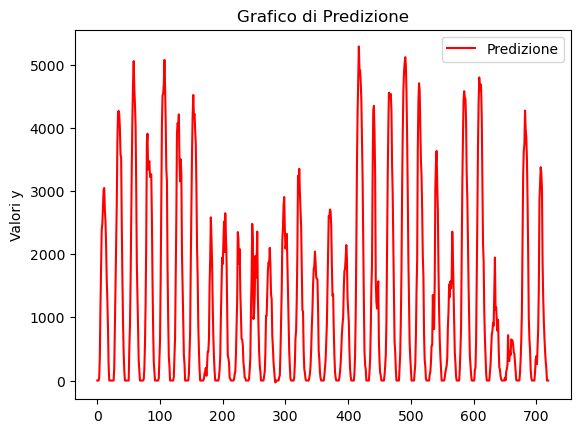

In [67]:
plt.plot(range(len(y_pred_A)), (df['Prediction']), label='Predizione', color='red', linestyle='-')
# Aggiungi una legenda
plt.legend()

# Aggiungi etichette agli assi
plt.ylabel('Valori y')

# Titolo del grafico
plt.title('Grafico di Predizione')

# Mostra il grafico
plt.show()

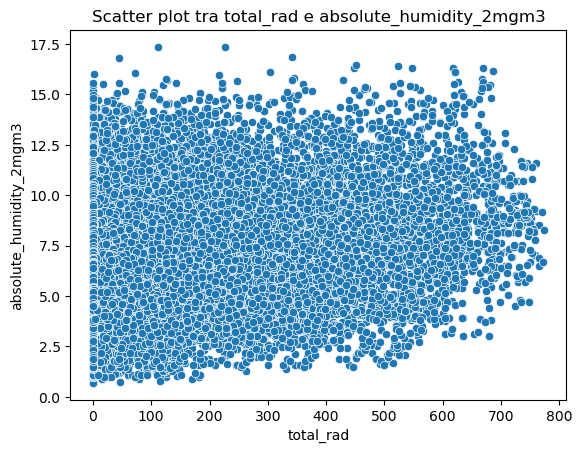

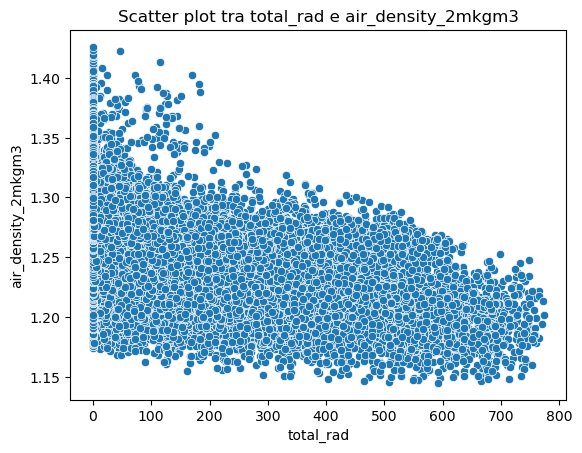

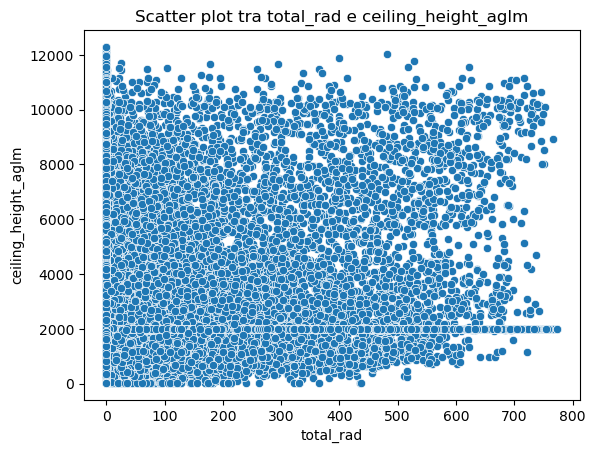

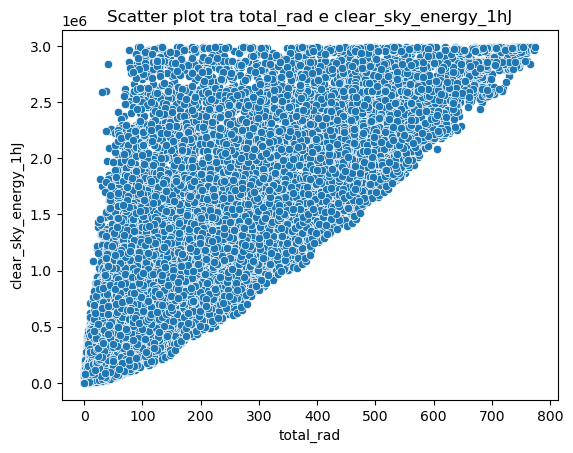

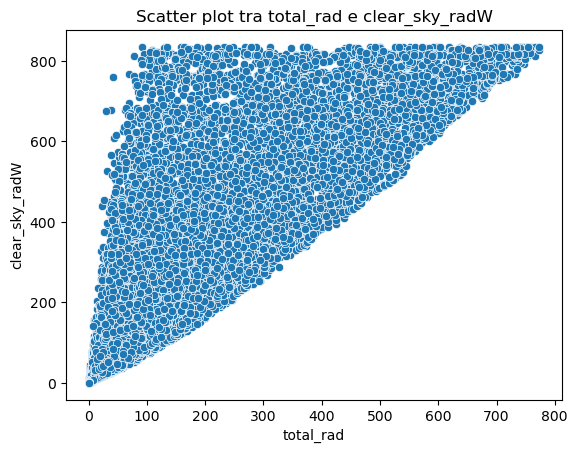

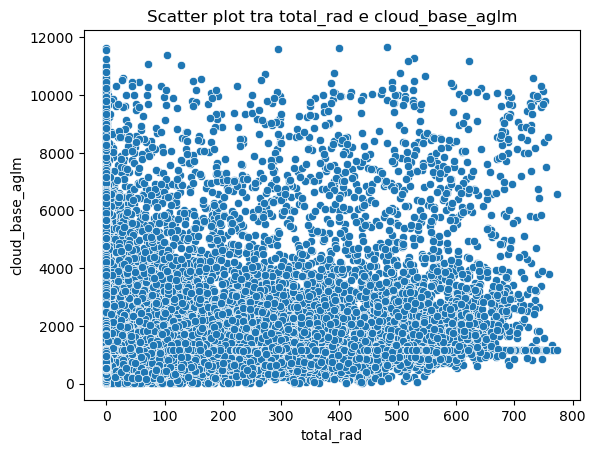

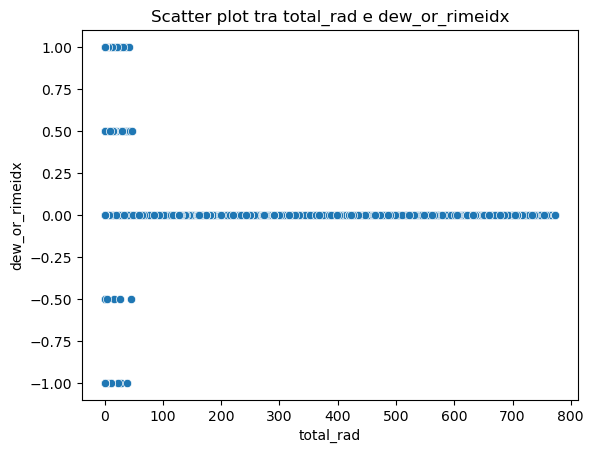

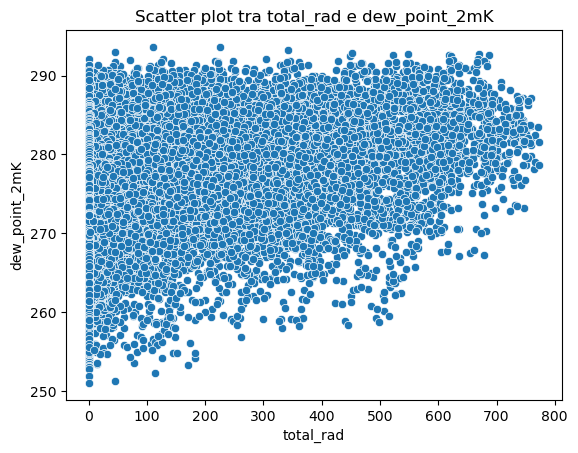

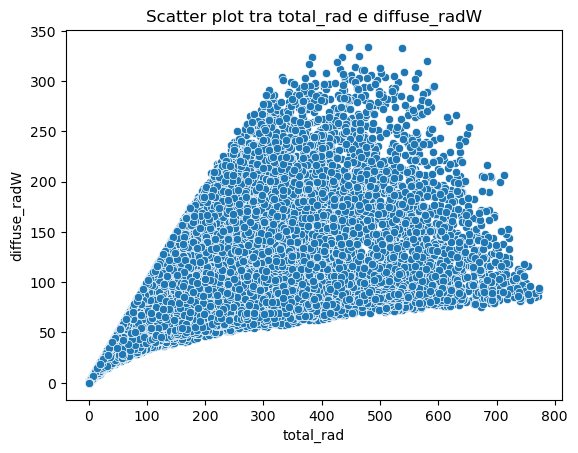

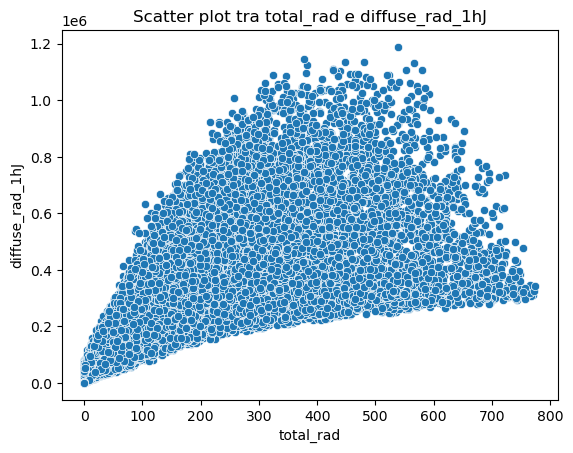

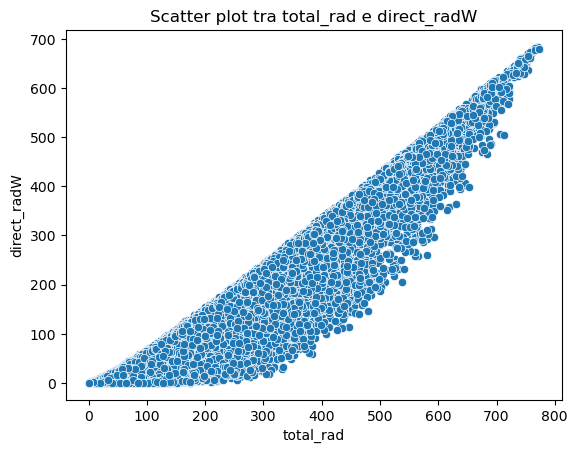

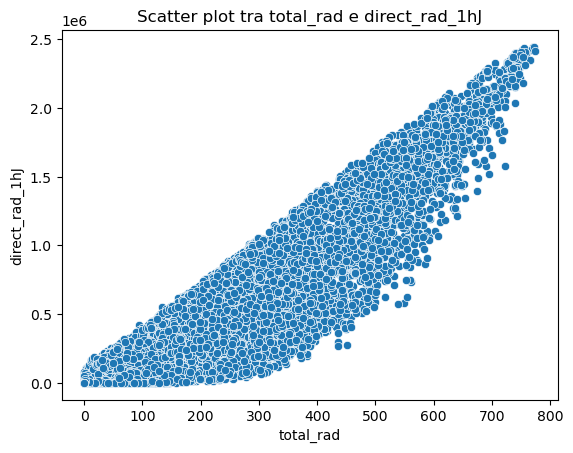

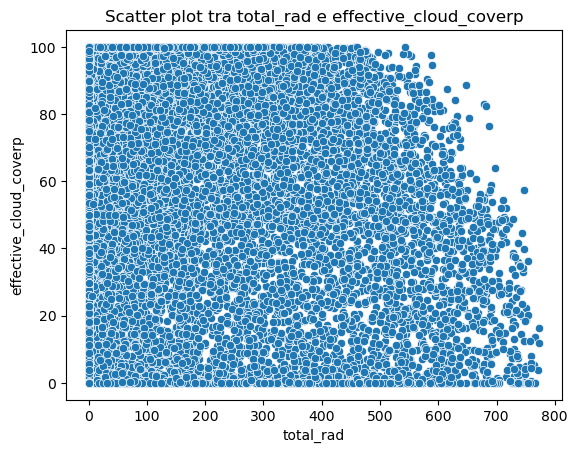

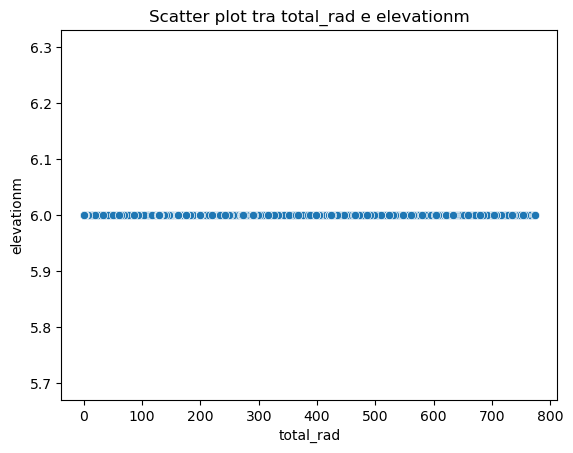

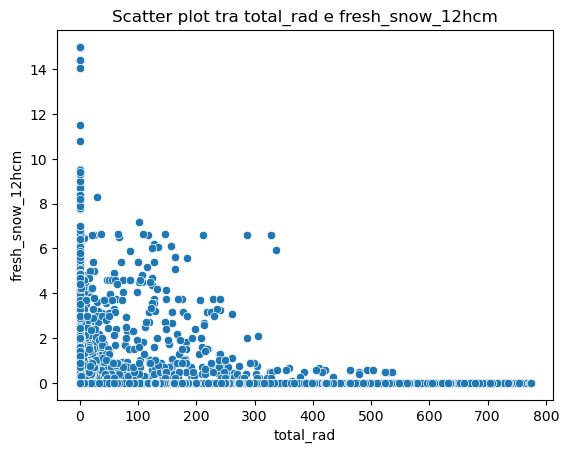

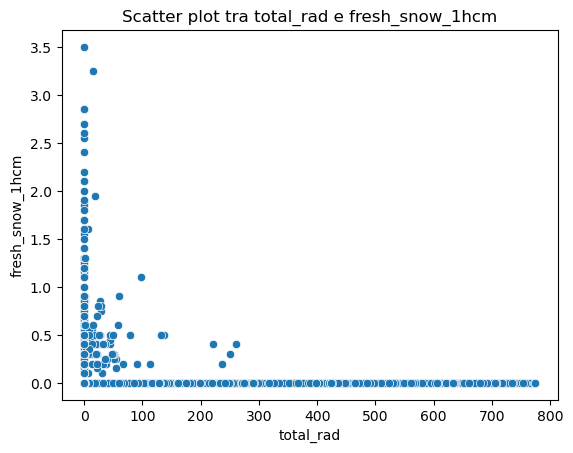

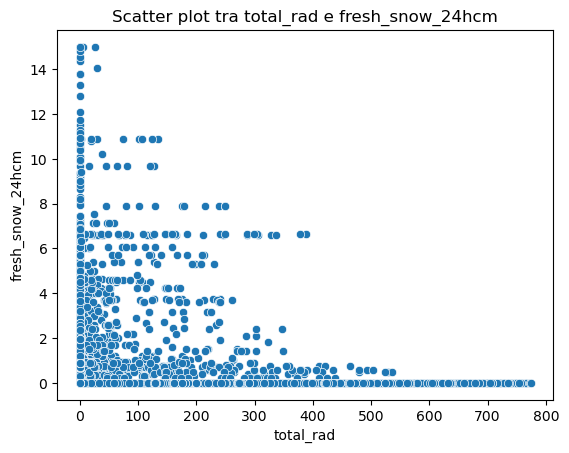

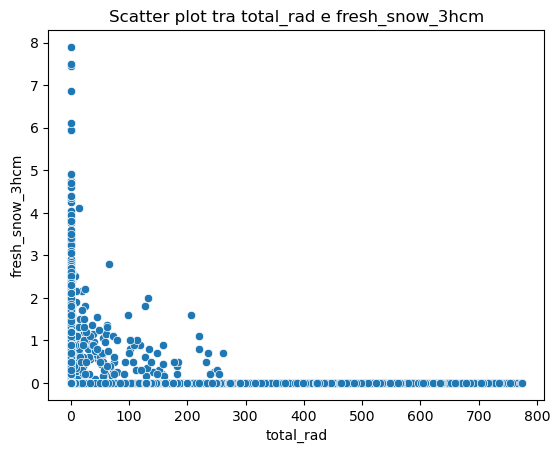

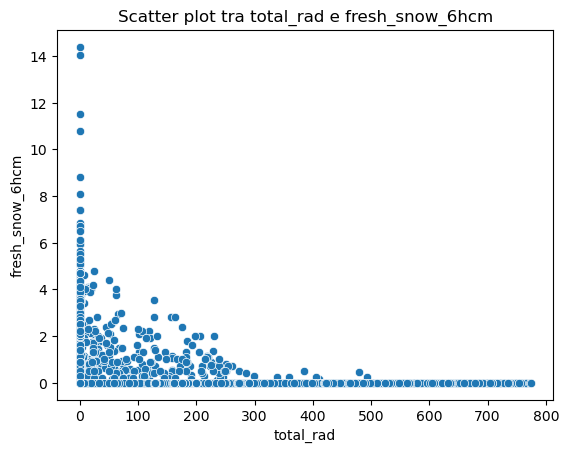

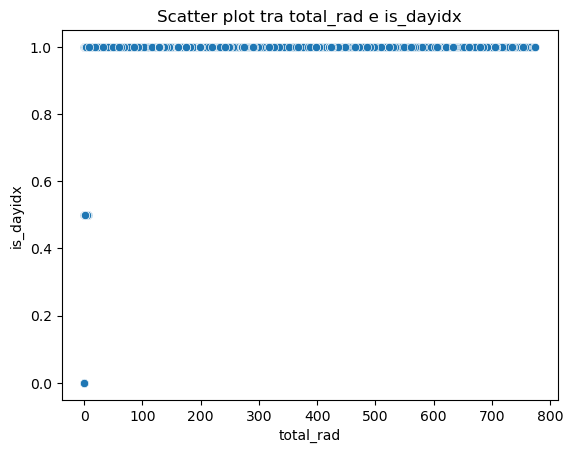

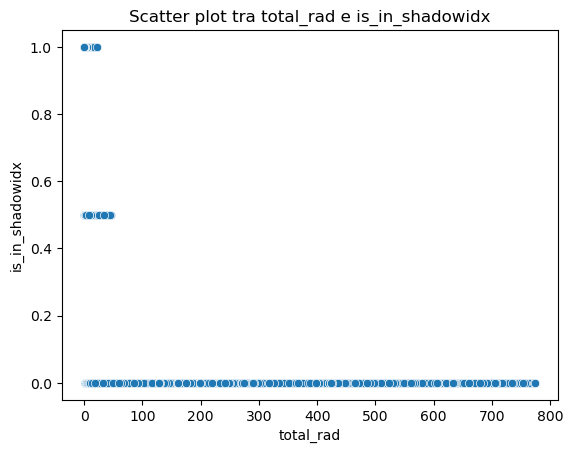

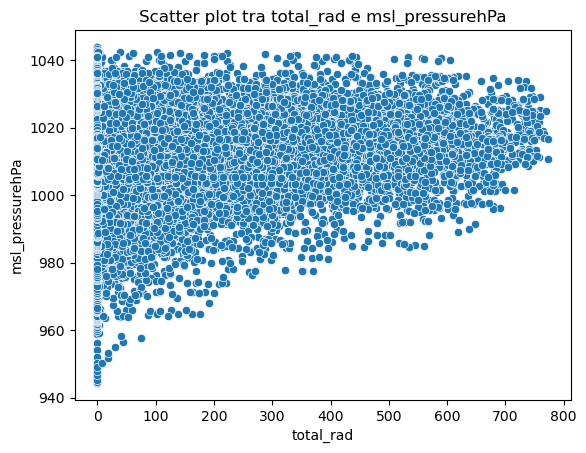

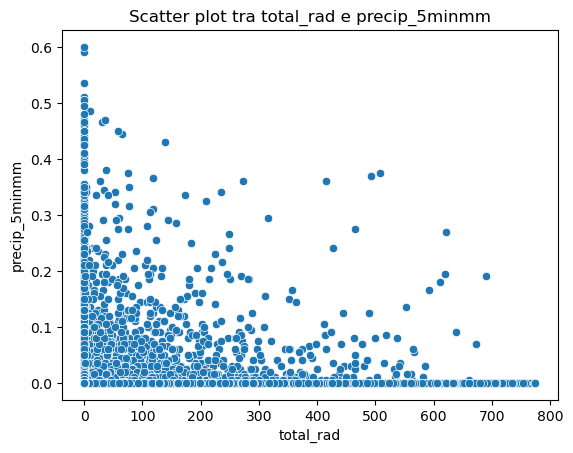

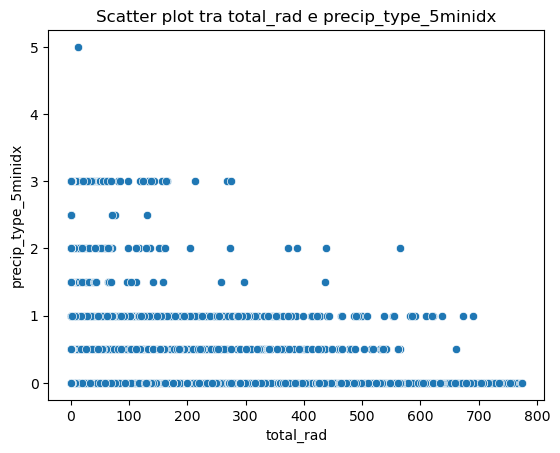

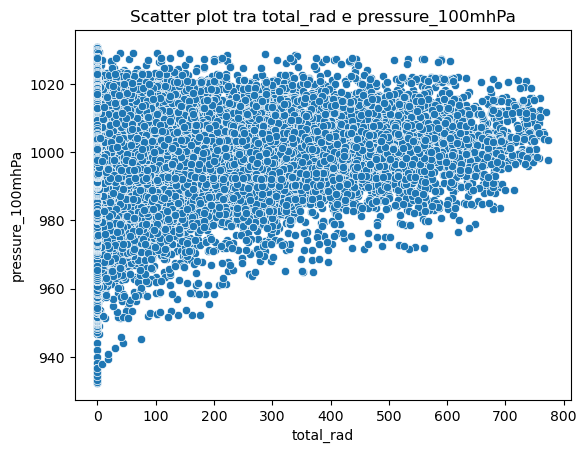

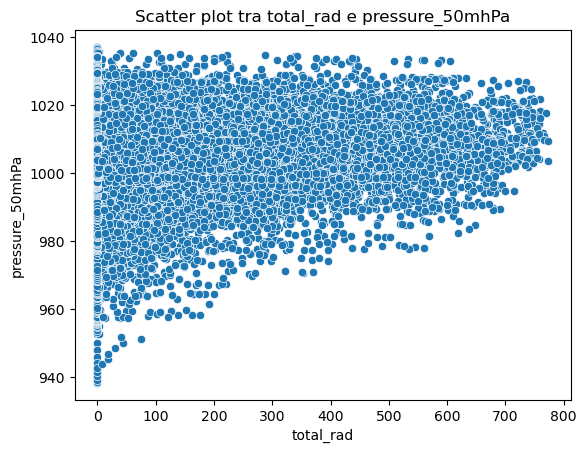

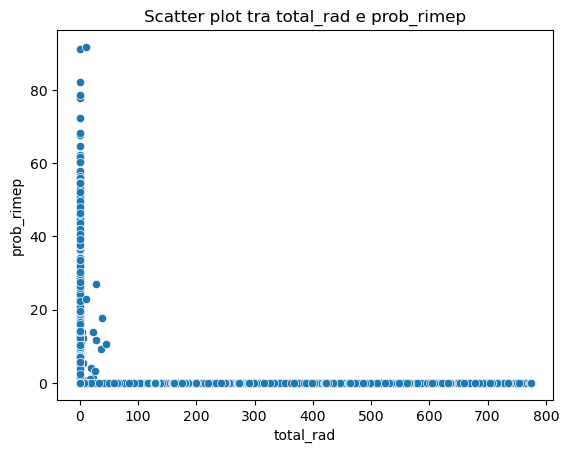

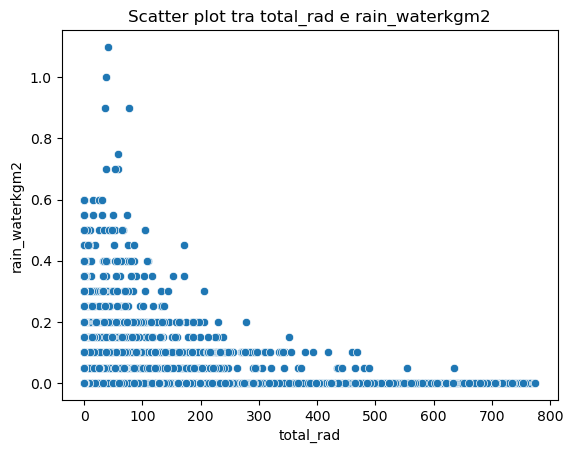

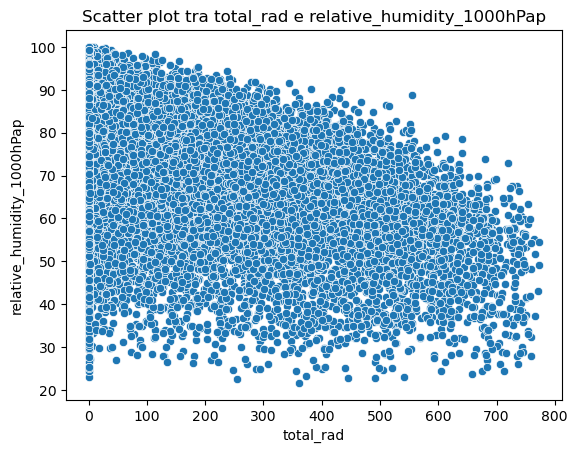

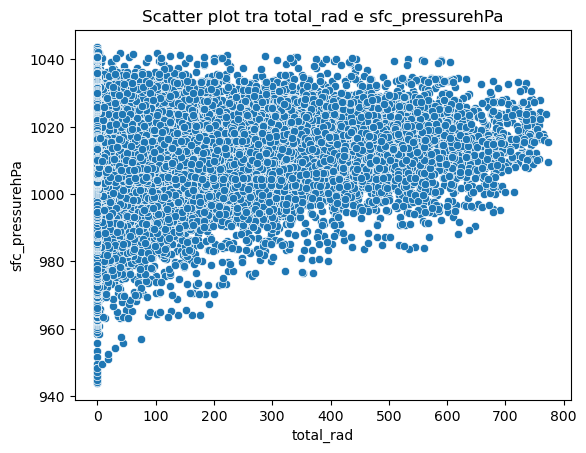

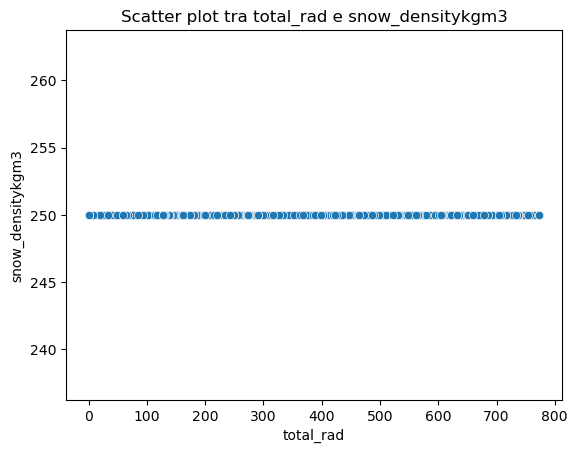

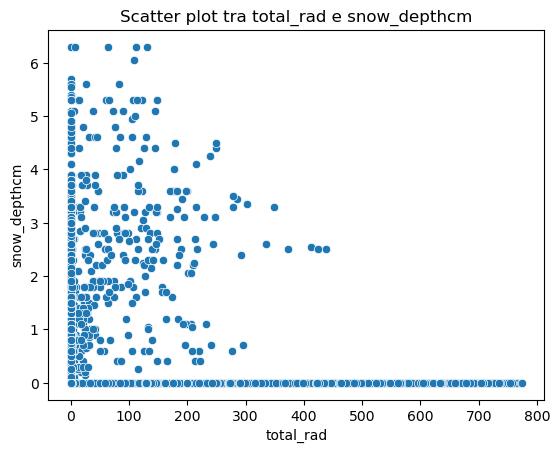

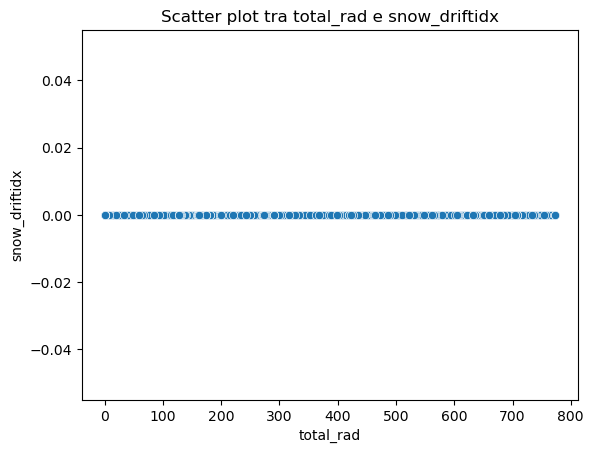

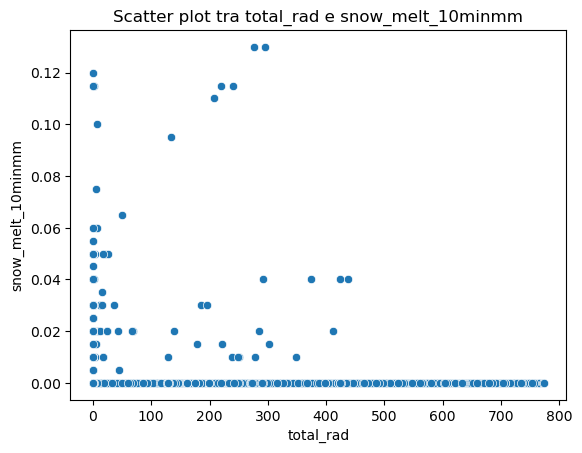

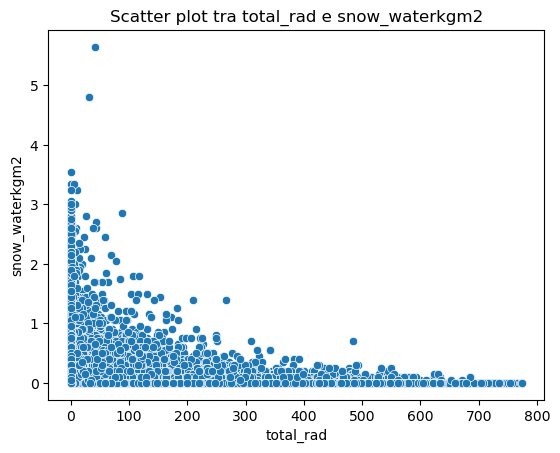

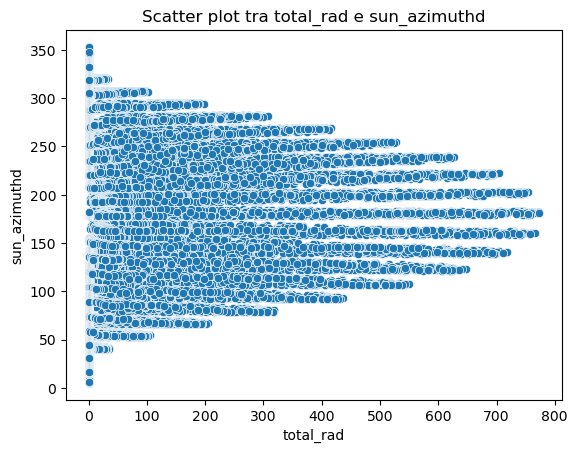

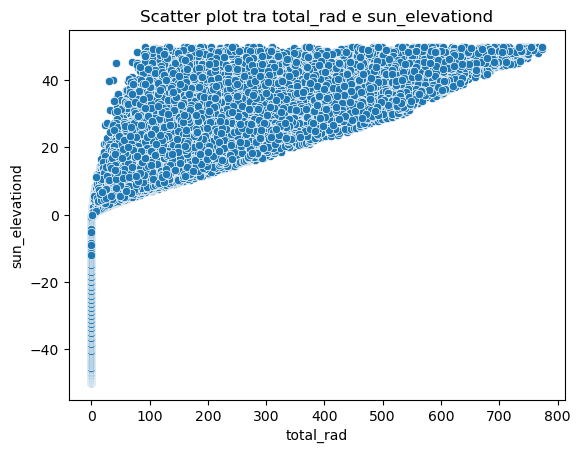

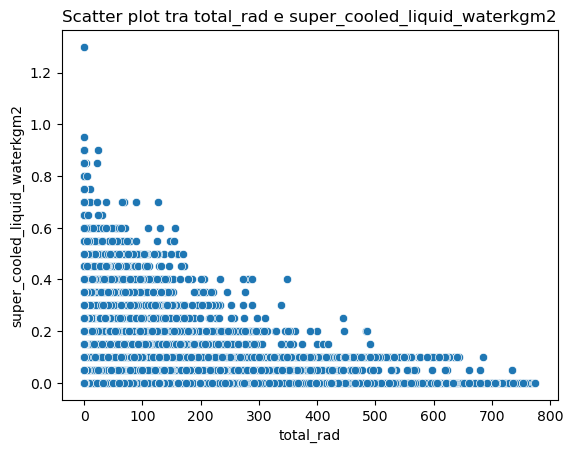

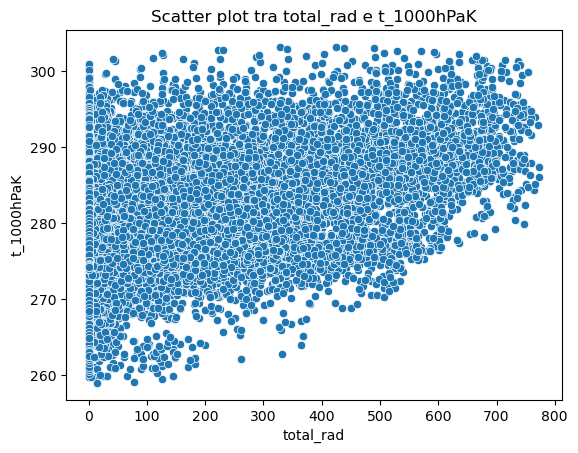

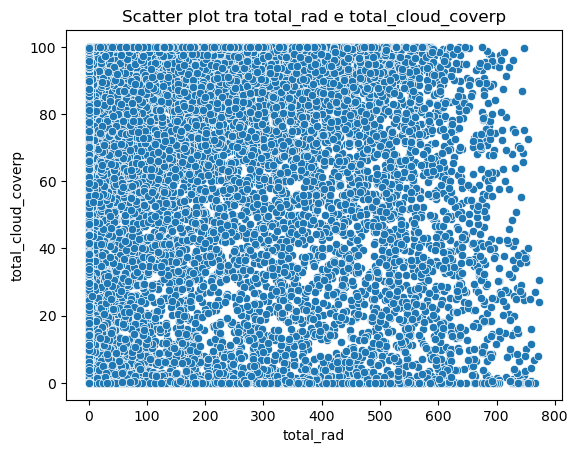

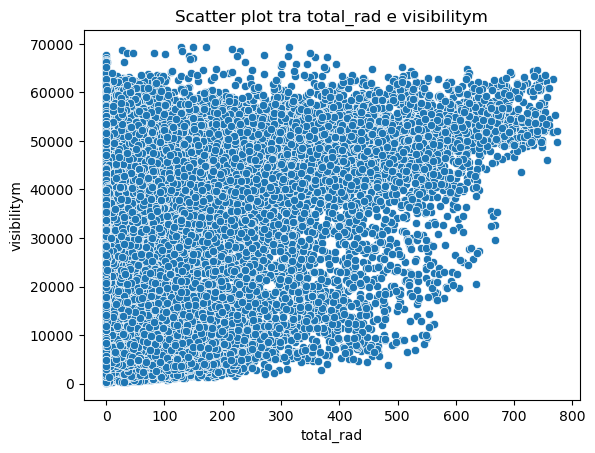

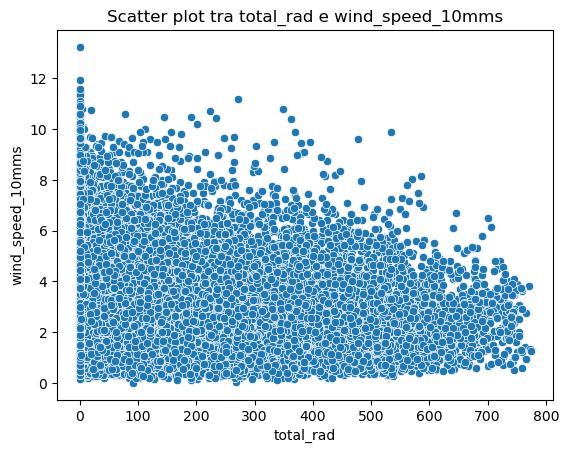

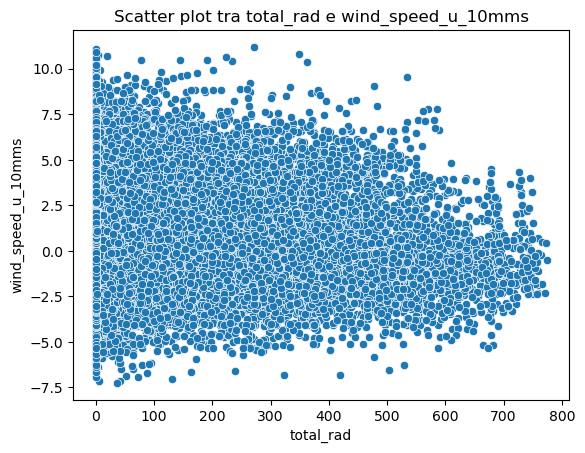

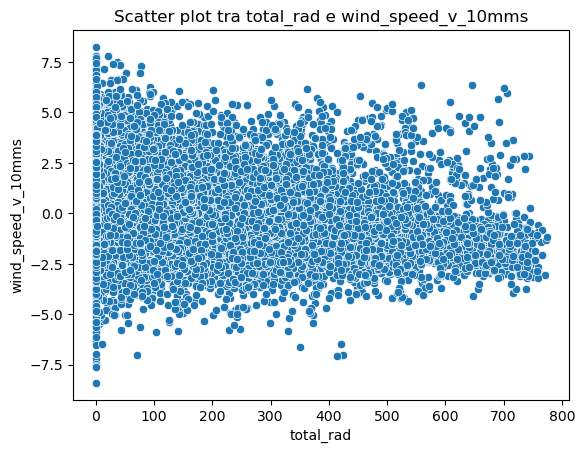

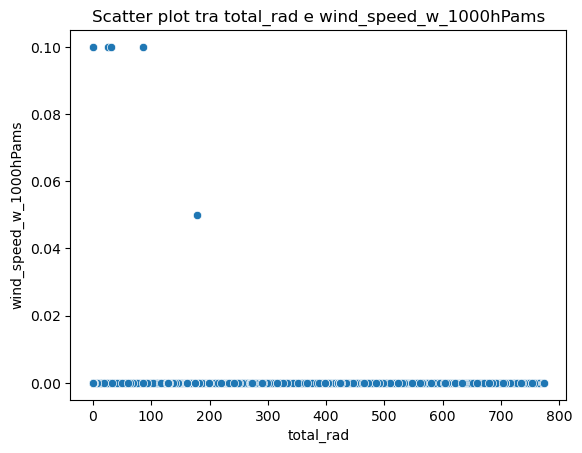

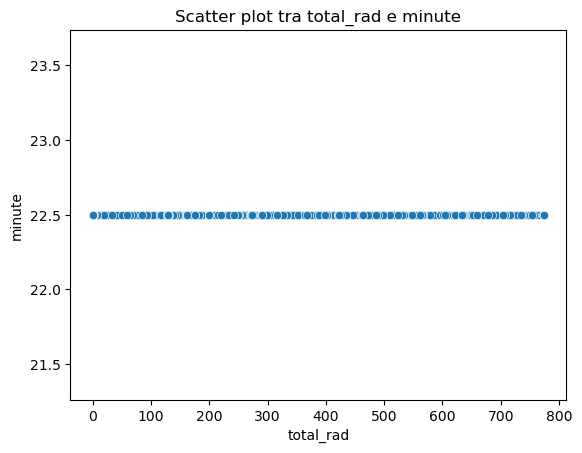

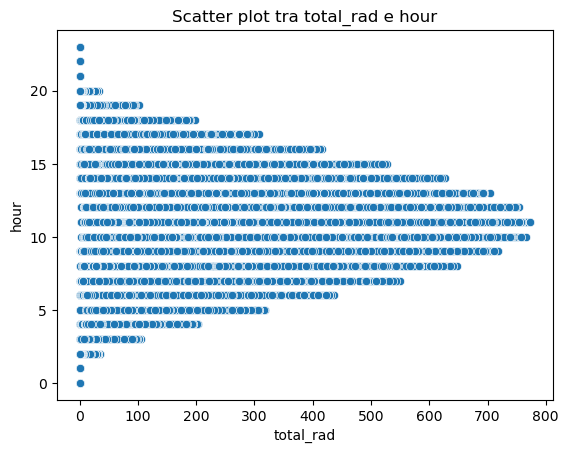

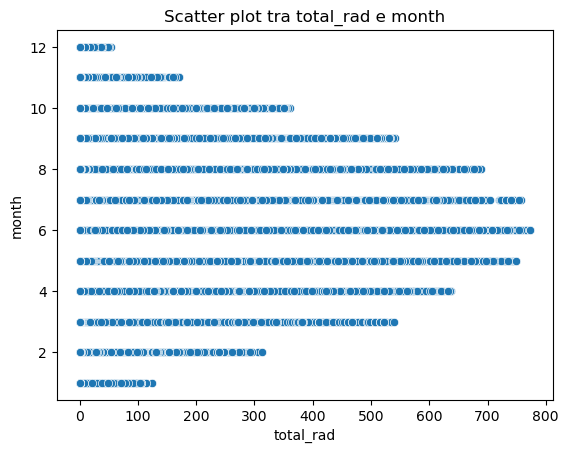

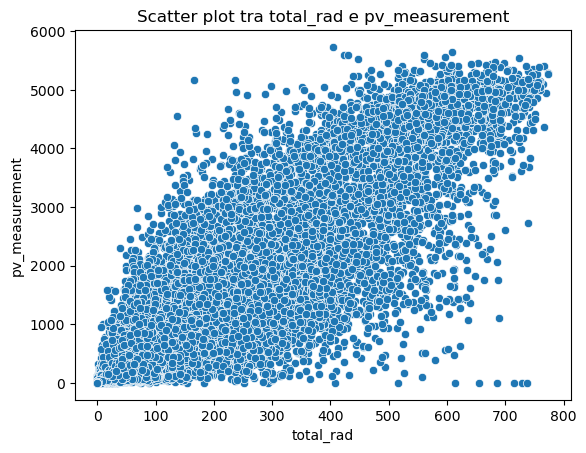

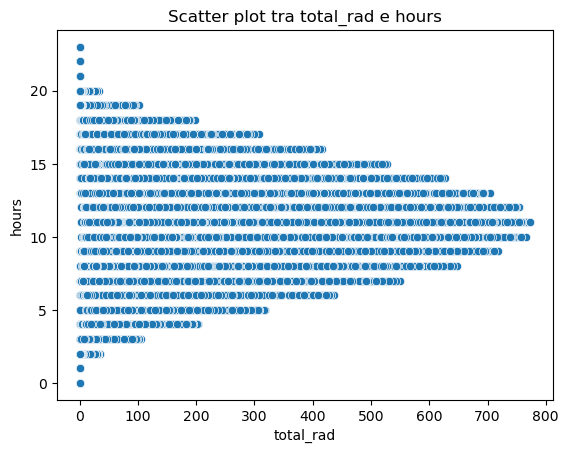

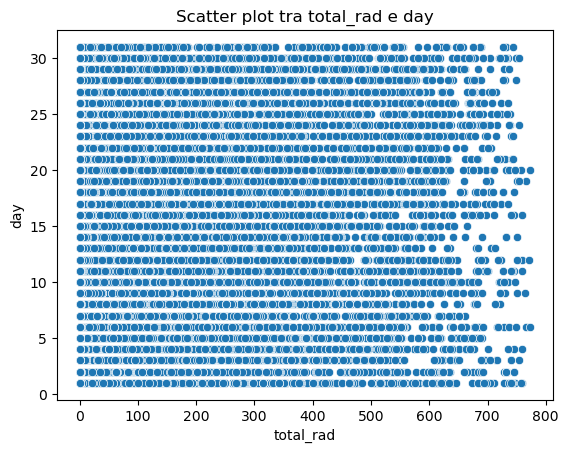

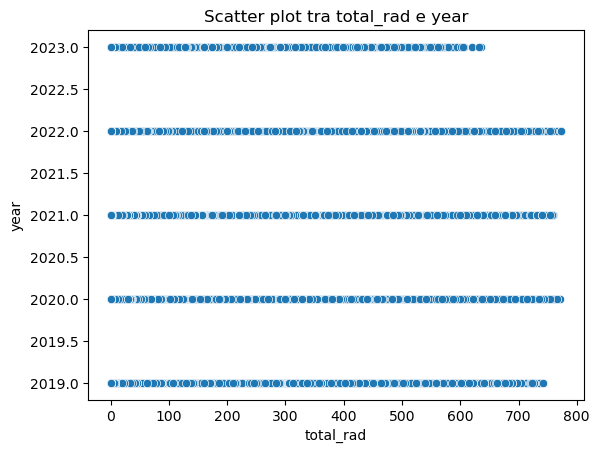

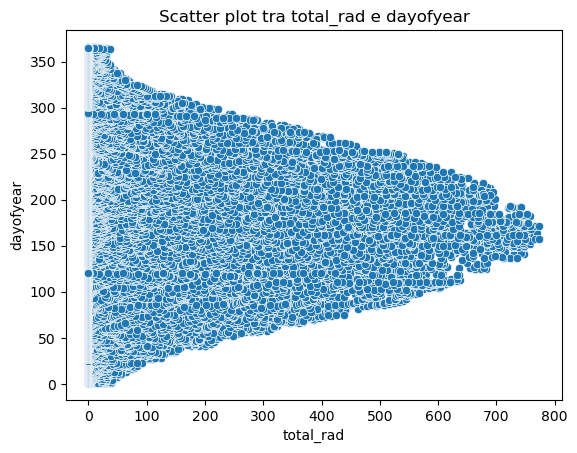

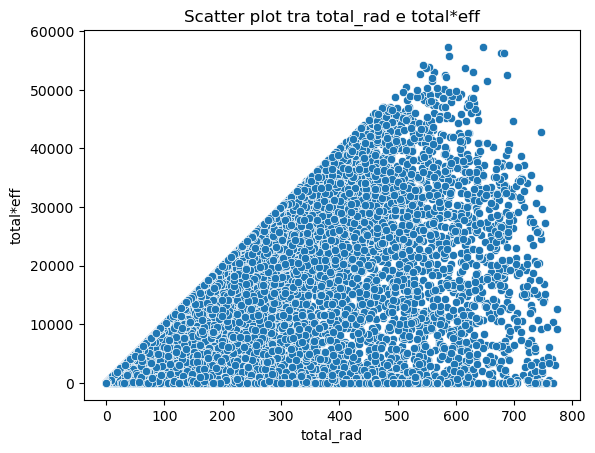

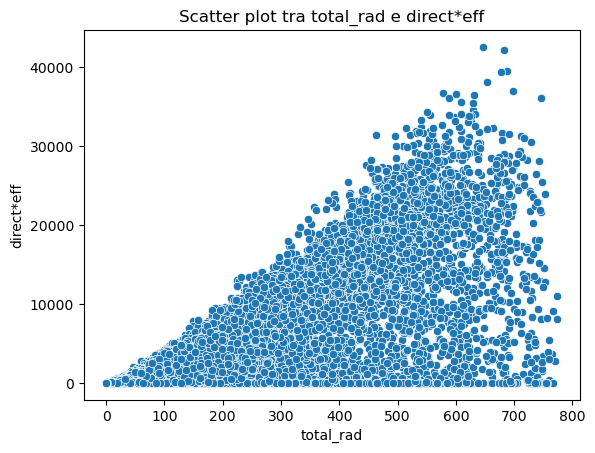

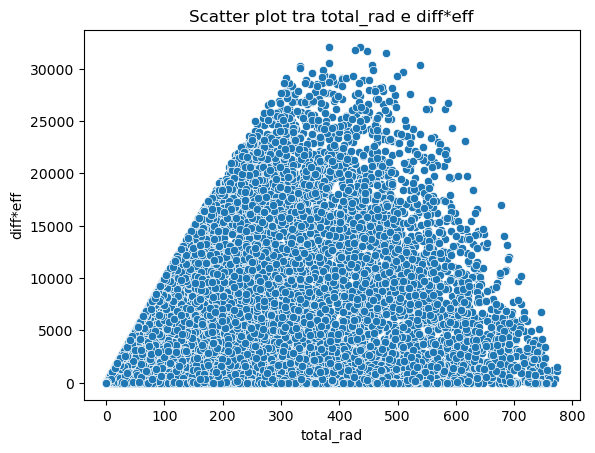

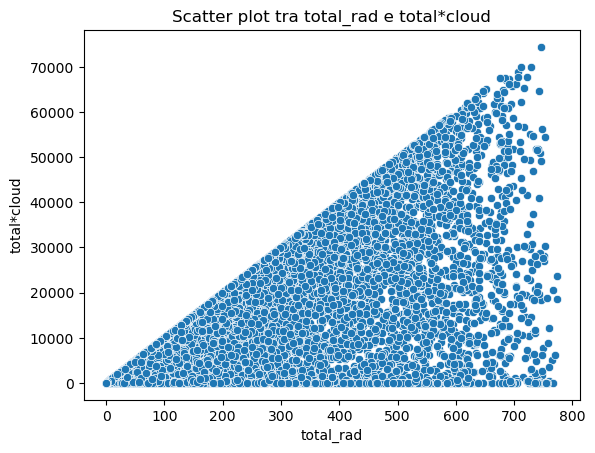

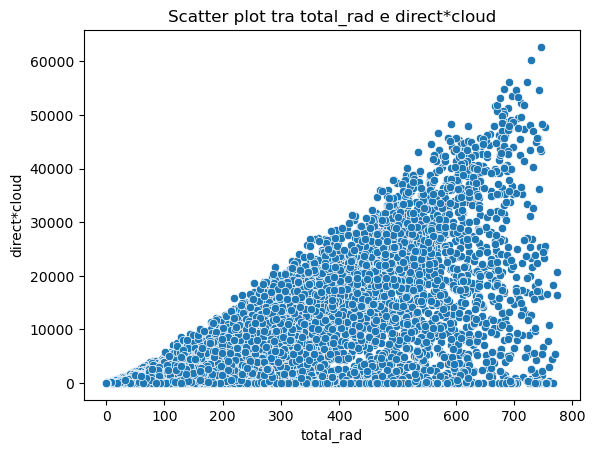

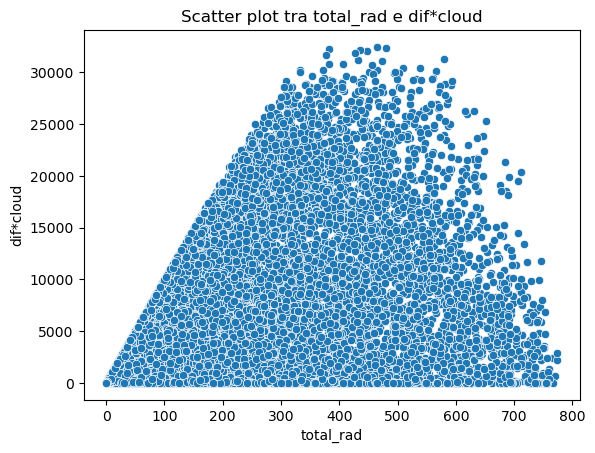

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
# Supponiamo che il tuo DataFrame sia chiamato 'df' e contenga tutte le tue feature.
# Sostituisci 'Nome della Feature' con il nome della feature di interesse.
df = train
feature_of_interest = 'total_rad'
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df)
# Itera attraverso tutte le altre feature nel DataFrame e crea scatter plot
for column in df.columns:
    if column != feature_of_interest:
        plt.figure()
        sns.scatterplot(data=df, x=feature_of_interest, y=column)
        plt.title(f"Scatter plot tra {feature_of_interest} e {column}")

plt.show()


In [73]:
train['total*cloud1'] = train['total*cloud'] * train['total_cloud_coverp']

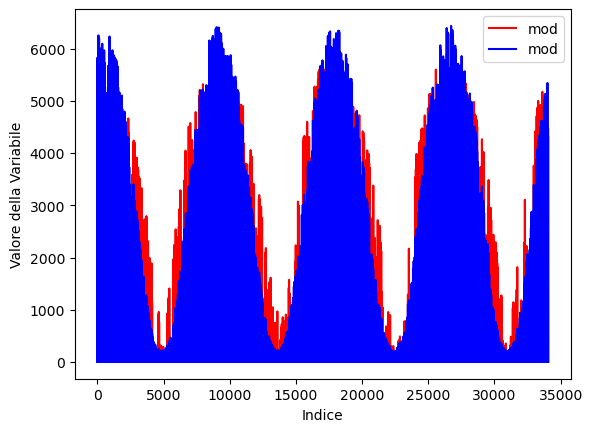

In [88]:
plt.plot(range(len(train['pv_measurement'])), (train['pv_measurement']),  color='r', label='mod')

plt.plot(range(len(train['total*cloud1'])), (train['total*cloud']*4),  color='b', label='mod')

# Aggiungi etichette agli assi
plt.xlabel('Indice')
plt.ylabel('Valore della Variabile')

# Aggiungi una legenda se necessario
plt.legend()

# Mostra lo scatter plot
plt.show()

In [84]:
train['total*cloud'] = train['total_rad'] + train['clear_sky_radW']
